In [1]:
'''

多被试分析。
每个被试在对应指标上都是一个平均值。

'''
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [2]:
data_path = 'E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\\6epoch_clean_ASSR\\'
sub_ids = [
            'pre2003','pre2004','pre2005',
          ]

list_epochs_4Hz = list()
list_epochs_30Hz = list()

for sub_id in sub_ids:
    epochs_4Hz = mne.read_epochs(data_path+sub_id+'_4hz-epo.fif')
    epochs_30Hz = mne.read_epochs(data_path+sub_id+'_6hz-epo.fif')
    list_epochs_4Hz.append(epochs_4Hz)
    list_epochs_30Hz.append(epochs_30Hz)

Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_ASSR\pre2003_4hz-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...   18200.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_ASSR\pre2003_6hz-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...   18200.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_ASSR\pre2004_4hz-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...   18200.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\

In [3]:
list_tmax = range(1,18)
list_snr_6hz = []
for tmax in list_tmax:
    tmin = 0.
    tmax = tmax
    fmin = 1.
    fmax = 20.
    sfreq = list_epochs_30Hz[0].info['sfreq']
    n_freq = 0
    # 每个被试都对应一个 psds,freqs，那么还需要做两个list了。
    # psds的数据结构是什么样子的呢，怎么进行统计分析呢？
    #  (n_epochs, n_channels, n_freqs).
    list_psds = list()
    list_freqs = list()
    list_snrs = list()
    # if input is of type Epochs, then psds will be of shape (n_epochs, n_channels, n_freqs)
    # psds的数据结构如此，那么可以考虑进行平均 SNR应该也是一样的道理。
    # 每个被试的psds先平均，然后再把所有的被试的数据平均psds拼接起来。
    channels = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']

    for i in range(len(sub_ids)):
        psds, freqs = mne.time_frequency.psd_welch(
            #关键设置 4 还是 30
            list_epochs_30Hz[i].copy().crop(tmin=tmin,tmax=tmax),
            picks = channels,
            n_fft=int(sfreq * (tmax - tmin)),
            # n_fft= 1000,
            n_overlap=0, n_per_seg=None,
            tmin=tmin, tmax=tmax,
            fmin=fmin, fmax=fmax,
            window='boxcar',
            verbose=False,
            average = 'mean'
        )

        def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
            """Compute SNR spectrum from PSD spectrum using convolution.

            Parameters
            ----------
            psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
                Data object containing PSD values. Works with arrays as produced by
                MNE's PSD functions or channel/trial subsets.
            noise_n_neighbor_freqs : int
                Number of neighboring frequencies used to compute noise level.
                increment by one to add one frequency bin ON BOTH SIDES
            noise_skip_neighbor_freqs : int
                set this >=1 if you want to exclude the immediately neighboring
                frequency bins in noise level calculation

            Returns
            -------
            snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
                Array containing SNR for all epochs, channels, frequency bins.
                NaN for frequencies on the edges, that do not have enough neighbors on
                one side to calculate SNR.
            """
            # Construct a kernel that calculates the mean of the neighboring
            # frequencies
            averaging_kernel = np.concatenate((
                np.ones(noise_n_neighbor_freqs),
                np.zeros(2 * noise_skip_neighbor_freqs + 1),
                np.ones(noise_n_neighbor_freqs)))
            averaging_kernel /= averaging_kernel.sum()

            # Calculate the mean of the neighboring frequencies by convolving with the
            # averaging kernel.
            mean_noise = np.apply_along_axis(
                lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
                axis=-1, arr=psd
            )

            # The mean is not defined on the edges so we will pad it with nas. The
            # padding needs to be done for the last dimension only so we set it to
            # (0, 0) for the other ones.
            edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
            pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
            mean_noise = np.pad(
                mean_noise, pad_width=pad_width, constant_values=np.nan
            )

            return psd / mean_noise
        snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                            noise_skip_neighbor_freqs=0)

        list_psds.append(psds)
        list_freqs.append(freqs)
        list_snrs.append(snrs)
    n_freq = psds.shape[2]
    place_6Hz = int(5/((fmax-fmin)/n_freq))
    psds_group = np.empty([len(sub_ids),len(channels),n_freq])
    snrs_group = np.empty([len(sub_ids),len(channels),n_freq])
    for i in range(len(sub_ids)):
        psds_group[i]=np.mean(list_psds[i],axis=0)
        snrs_group[i]=np.mean(list_snrs[i],axis=0)

    '''

    '''
    freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                       np.where(np.ceil(freqs) == fmax - 1)[0][0])
    psds_plot = 10 * np.log10(psds_group)
    psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
    psds_std = psds_plot.std(axis=(0, 1))[freq_range]

    # SNR spectrum
    snr_mean = snrs_group.mean(axis=(0, 1))[freq_range]
    snr_std = snrs_group.std(axis=(0, 1))[freq_range]

    print(snr_mean[place_6Hz])
    list_snr_6hz.append(snr_mean[place_6Hz])



<decorator-gen-201>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function ``psd_welch()`` is deprecated; for Raw/Epochs/Evoked instances use ``spectrum = instance.compute_psd(method="welch")`` instead, followed by ``spectrum.get_data(return_freqs=True)``.
<decorator-gen-201>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function ``psd_welch()`` is deprecated; for Raw/Epochs/Evoked instances use ``spectrum = instance.compute_psd(method="welch")`` instead, followed by ``spectrum.get_data(return_freqs=True)``.


1.2389722398403975
1.29292938749606
1.3993884458432948
1.4872469060858444
1.4761742681690846
1.4799931218774587
1.635711025360828
1.6914191400595138
1.821546284406708
1.8771613195142107
1.8939869795678907
2.0354784184253876
2.1358431906755224
2.2506667684038617
2.3526236299454633
2.504426289763608
2.5649651025110467


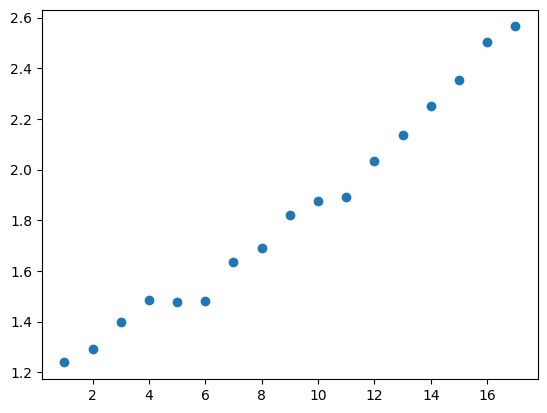

In [4]:
x = np.array(list_tmax)
y = np.array(list_snr_6hz)
plt.scatter(x,y)

In [29]:
'''
ndarray在某个方向上进行平均
'''
%matplotlib qt
psds_group = np.empty([len(sub_ids),len(channels),n_freq])
snrs_group = np.empty([len(sub_ids),len(channels),n_freq])
for i in range(len(sub_ids)):
    psds_group[i]=np.mean(list_psds[i],axis=0)
    snrs_group[i]=np.mean(list_snrs[i],axis=0)

'''

'''
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds_group)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs_group.mean(axis=(0, 1))[freq_range]
snr_std = snrs_group.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 10], xlim=[fmin, fmax])
fig.show()


In [22]:
'''
读取不同分析时间的，在4Hz上的SNR，然后以时间为横轴，SNR为纵轴作图。

问题：为什么

'''




2.504426289763608

In [15]:
'''
时频分析
https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py

这里对应生成的是power和ITC，ITC肯定是一个被试一个了（试次间参数）。
ERSP可以选择（相对基线的扰动）。

那么最简单的想法：就是直接组平均，  power.data就是ndarray[channel，frequency，time]，那么同样的只要增加一个被试维度，平均一下就行了。
'''
freqs = np.logspace(*np.log10([1, 50]), num=8)
freqs = np.linspace(1,40,num=40)
n_cycles = freqs / 2.  # different number of cycle per frequency

#随便弄一个power出来备用。
power, itc = tfr_morlet(list_epochs_4Hz[0], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
ndarry_power_group = np.empty([len(sub_ids),62,40,6234])
ndarry_itc_group = np.empty([len(sub_ids),62,40,6234])

for j in range(len(sub_ids)):
    power, itc = tfr_morlet(list_epochs_30Hz[j], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
    ndarry_power_group[j] = power.data
    ndarry_itc_group[j] = itc.data


In [16]:
ndarry_power_group_average = np.mean(ndarry_power_group,axis=0)
power.data = ndarry_power_group_average
%matplotlib qt
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power', fmin=0,fmax=40, vmax=1.5,vmin=-1.5)
power.plot([33], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[33])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_19284\3428265250.py:8: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,


Applying baseline correction (mode: logratio)


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_19284\3428265250.py:11: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,


Applying baseline correction (mode: mean)


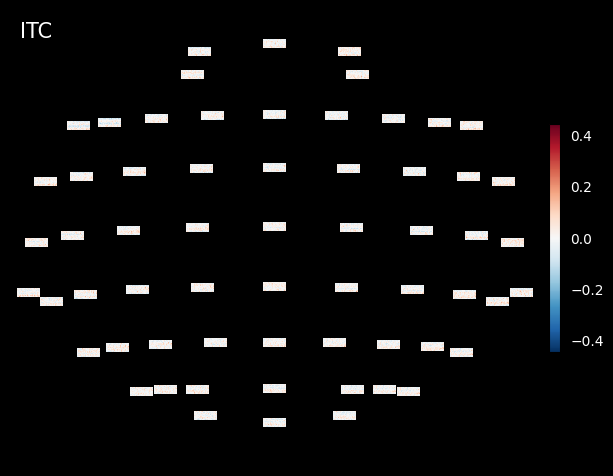

In [17]:
ndarry_itc_group_average = np.mean(ndarry_itc_group,axis=0)
itc.data = ndarry_itc_group_average
itc.plot_topo(baseline=(-0.5, 0), mode='mean', title='ITC')